#### Инициализация

In [1]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

'''Частота излучения и сечение поглощения'''
frequency = 709078373.01 * 10 ** 6 # [Hz]
c = 299792458 # [m/s]
wavelength = (c/frequency) * 10 ** 2 # [cm]
crossection = (3 * wavelength ** 2 ) / (2 * np.pi) # [cm^2]

rows, columns = (768, 1024)
'''Калибровка'''# [cm/px]
K = 0.0008332755449029944

#### Обработка поглощения

In [116]:
file = "image_0"
#directory = r"..//" #EXPERIMENTS
#directory = r"../..//" #desktop
directory = r"../2025-10-09_densityScan_b=75/d=6.58V//" #EXPERIMENTS

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + file + ".tif") #initially a grayscale image

shots = []
try:
    while True:
        frame = np.array(img)
        shots.append(frame)
        img.seek(img.tell() + 1) #go to next frame
except EOFError: #end of frames case
    pass

I_atoms = shots[0] #I
I_lbeam = shots[1] #I0
bias = shots[2]

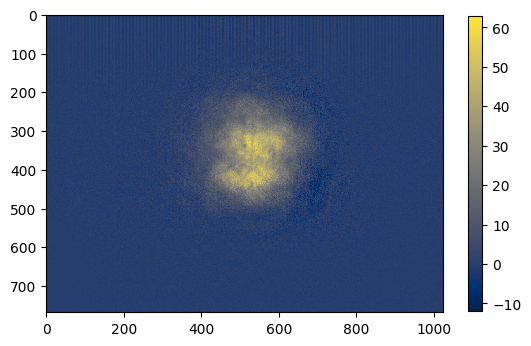

In [117]:
'''Приведение к uint16 и замена нулей, чтобы не возникало ошибок при делении матриц'''
num = (I_atoms - bias).astype(np.uint16) + 1
denom = (I_lbeam - bias).astype(np.uint16) + 1

'''Определение пропускания T(x,y)'''
T = (num/denom).astype(np.float32)

'''Визуализация'''
D = I_lbeam.astype(np.int16)-I_atoms.astype(np.int16)
plt.imshow(D, cmap="cividis", interpolation="none")
plt.colorbar(shrink=.8)

#### Поиск центра облака

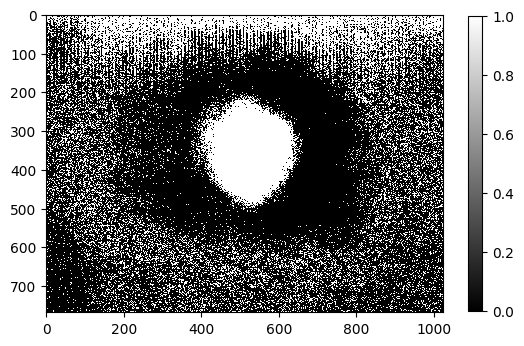

In [118]:
TRSH = .85
'''Фильтрация пропускания ниже порогового значения'''
_, binary = cv2.threshold(T, TRSH, 1, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV:
#  ≤ TRSH = белые
#  > TRSH = черные

'''Визуализация'''
plt.imshow(binary, cmap="gray", interpolation='none')
plt.colorbar(shrink=.8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..256.0].


Критическое пропускание	Tc: 0.3636363744735718
Критическая точка	C: (340, 508) 


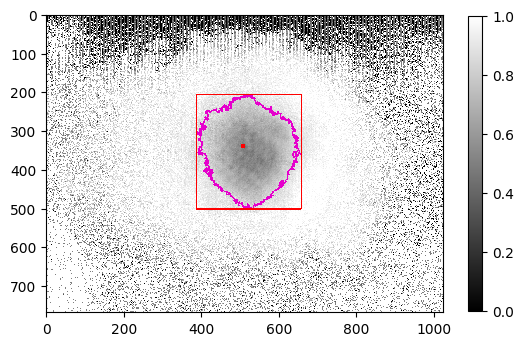

In [119]:
'''Выделение контура поглощения'''
contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
assert contours != (), "Err: no contours found"

'''Фильтрование верхнего шума'''
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if y > binary.shape[0] * 0.2:
        filtered_contours.append(contour)
assert filtered_contours != (), "Err: no contours meets filtering condition"

'''Формирование маски'''
largest_contour = max(filtered_contours, key=cv2.contourArea)
ROI = np.zeros_like(T, dtype=np.uint8)
cv2.drawContours(ROI, [largest_contour], -1, 255, thickness=cv2.FILLED)

'''Нахождение минимума пропускания в ней'''
min_val, _, (jc, ic), _ = cv2.minMaxLoc(T, mask=ROI)
print(f"Критическое пропускание\tTc: {min_val}\nКритическая точка\tC: {(ic, jc)} ")

'''Оопределение ограничивающего прямоугольника'''
j_min, i_min, width, height = cv2.boundingRect(largest_contour)
j_max = j_min + width
i_max = i_min + height

'''Отрисовка полученного контура'''
output = cv2.cvtColor(T, cv2.COLOR_GRAY2BGR)  # Переводим в BGR для рисования
cv2.drawContours(output, [largest_contour], -1, (.9, 0, .8), 2)
cv2.circle(output, (jc, ic), 6, (1., 0, 0), -1)
cv2.rectangle(output, (j_min, i_min), (j_max, i_max), (1., 0, 0), 2)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output, interpolation='none', cmap="gray")
plt.colorbar(shrink=.8)

#### Обработка центральных осей

fwhmx: 182.569 ± 2.115 px
peak absorption: 51.734% ± 0.408%
________________________________
χ²-reduced: 0.001
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)


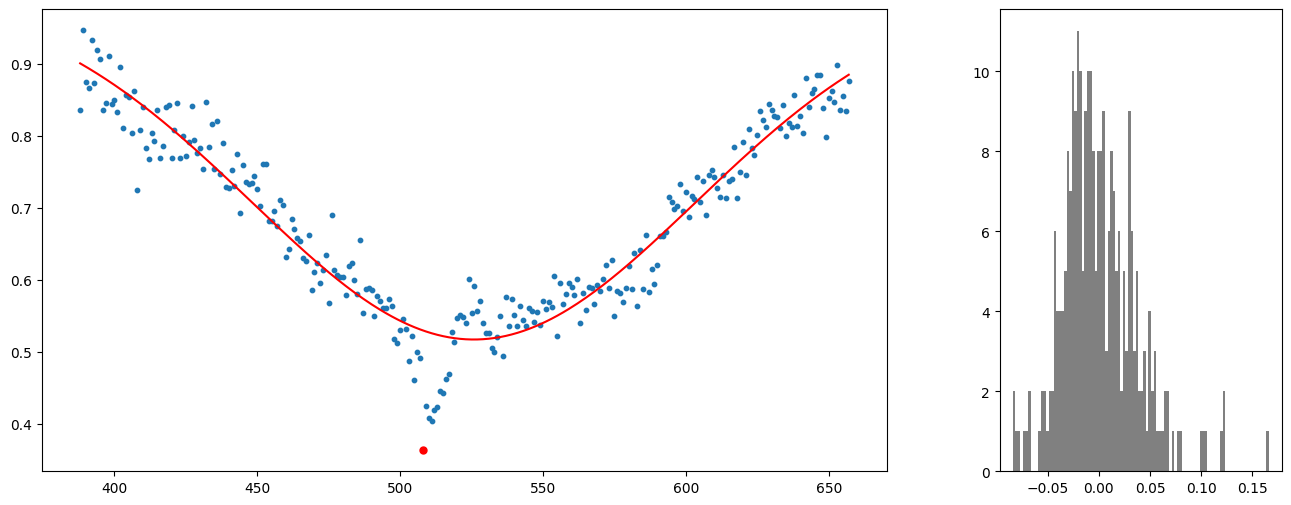

In [ ]:
'''Профиль по оси j (для величины wx)'''
data = 1-T[ic, j_min:j_max] #без медианного сглаживания шумы слишком сильные, чтобы сигнал был различим
arg = np.arange(j_min, j_max, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
wx = out.params["sigma"].value
fwhmx = out.params["fwhm"].value
peak = 1-out.params["height"].value

'''Вывод фитирования'''
print("fwhmx: %.3f ± %.3f px" % (fwhmx, out.params["fwhm"].stderr)) #stderr соответствует p = 0.68 (1-сигма)
#print("wx: %.3f ± %.3f px" % (wx, out.params["sigma"].stderr))
print("peak absorption: %.3f%% ± %.3f%%" % (peak*100, out.params["height"].stderr*100))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
#print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

'''Визуализация'''
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(jc, 1-data[jc-j_min], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

fwhmy: 205.893 ± 2.183 px
________________________________
χ²-reduced: 0.001
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)


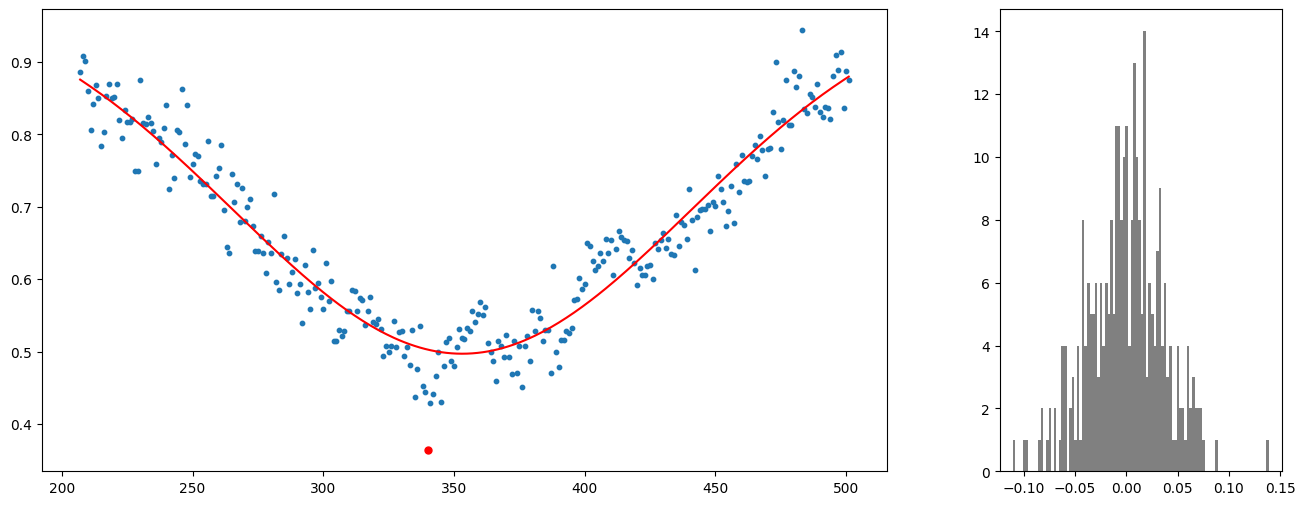

In [ ]:
'''Профиль по оси i (для величины w_y)'''
data = 1-T[i_min:i_max, jc]
arg = np.arange(i_min, i_max, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg)
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
wy = out.params["sigma"].value
fwhmy = out.params["fwhm"].value

'''Вывод фитирования'''
print("fwhmy: %.3f ± %.3f px" % (fwhmy, out.params["fwhm"].stderr))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
#print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

'''Визуализация'''
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(ic, 1-data[ic-i_min], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

#### Расчёт концентрации

n0: 4.77e+09 cm^-3
N:  2.28e+07 cm^-3
FWHMx:  1.52 mm


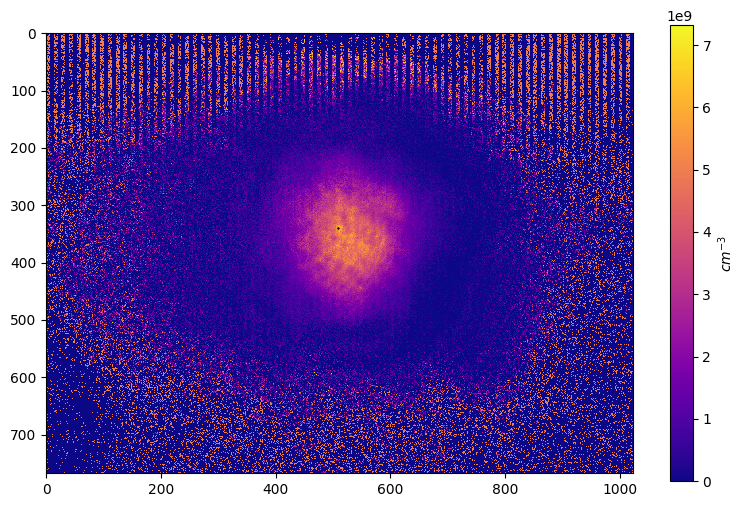

In [128]:
'''Профиль концентрации атомов n(x, y)'''
n = -np.log(T)/(np.sqrt(2*np.pi)*wx*K*crossection).astype(np.float32)

'''Порог фильтрации'''
#_, nm, _, (j_peak, i_peak) = cv2.minMaxLoc(n, mask=ROI)
nm = -np.log(T[ic, jc])/(np.sqrt(2*np.pi)*wx*K*crossection).astype(np.float32)
'''Пиковая плотность'''
n0 = -np.log(peak)/(np.sqrt(2*np.pi)*wx*K*crossection).astype(np.float32)
'''Число атомов во всём облаке'''
N = -(2*np.pi*wx*K*wy*K*np.log(peak)/crossection).astype(np.float32)

'''Вывод значений'''
print("n0: %.2e cm^-3" % n0)
print("N:  %.2e cm^-3" % N)
print("FWHMx:  %.2f mm" % (fwhmx*K*10))

'''Фильтрация физичных плотностей'''
for i in range(rows): #rows
    for j in range(columns): #columns
        if n[i, j] < 0.:
            n[i, j] = 0.
        elif n[i, j] > nm:
            n[i, j] = 0.

'''Визуализация'''
plt.figure(figsize=(8, 6))
plt.imshow(n, cmap="plasma", interpolation="none")
plt.plot(jc, ic, 'ko', markersize=.75)
plt.colorbar(shrink=.8, label="$cm^{-3}$")
plt.tight_layout()
plt.show()
#plt.savefig(directory + file + "_n0=%.3e.png"%n0)